# Telecom Revenue Forecasting: Ghana Market Analysis

Ghana's telecom market is highly competitive with significant churn challenges. This analysis forecasts revenue trajectories under different churn scenarios to:

### Key Questions
- What is our 12-month revenue trajectory at current churn rates?
- How much revenue could we gain by reducing churn by 5 percentage points?
- What's the downside risk if churn increases?
- What's the ROI of investing in customer retention?

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

---

## 1. Data Loading & Current State Analysis

In [2]:
# Load customer data
df = pd.read_csv('../data/ghana_telecom_customers.csv')

print(f"Total Customers: {len(df):,}")
print(f"Features: {df.shape[1]}")

Total Customers: 100,000
Features: 20


In [3]:
print(f"Columns: {', '.join(df.columns.tolist())}")

Columns: customer_id, region, locality_type, subscription_type, tenure_months, device_type, monthly_data_usage_gb, monthly_voice_mou, monthly_sms_count, estimated_monthly_arpu_gh, voice_revenue_gh, data_revenue_gh, support_calls_last_3months, plan_changes_last_year, recharge_frequency_monthly, night_data_user, social_media_data_gb, customer_segment, churn_risk_score, churned


### Subscriber base

In [ ]:
total_subscribers = len(df)
churned_customers = df['churned'].sum()
active_customers = total_subscribers - churned_customers
print(f"Total Subscribers: {total_subscribers:,}")
print(f"Active Customers: {active_customers:,}")
print(f"Churned Customers: {churned_customers:,}")

Total Subscribers: 100,000
Active customers: 75,350
Churned customers: 24,650


### Churn Rates

In [5]:
annual_churn_rate = df['churned'].mean()
monthly_churn_rate = 1 - (1 - annual_churn_rate) ** (1/12)
print(f"Annual Churn Rate: {annual_churn_rate:,}")
print(f"Monthly Churn Rate: {monthly_churn_rate:,}")

Annual Churn Rate: 0.2465
Monthly Churn Rate: 0.023309557172008


### Revenue metrics

In [6]:
avg_arpu = df['estimated_monthly_arpu_gh'].mean()
avg_arpu = df['estimated_monthly_arpu_gh'].mean()
total_monthly_revenue = active_customers * avg_arpu
revenue_lost_to_churn = churned_customers * avg_arpu

print(f"Average ARPU: GHc{avg_arpu:,.2f} per month")
print(f"Current Monthly Revenue: GHc{total_monthly_revenue:,.2f}")
print(f"Annual Revenue (current active): GHc{total_monthly_revenue*12:,.2f}")
print(f"Revenue Lost to Churn: GHc{revenue_lost_to_churn:,.2f}/month")
print(f"Annual Revenue at Risk: GHc{revenue_lost_to_churn*12:,.2f}")

Average ARPU: GHc348.31 per month
Current Monthly Revenue: GHc26,245,197.90
Annual Revenue (current active): GHc314,942,374.81
Revenue Lost to Churn: GHc8,585,854.39/month
Annual Revenue at Risk: GHc103,030,252.67


**Churn is a major revenue drain:** With 24,650 customers churned out of 100,000, we're losing nearly a quarter of our customer base annually. At GH₵348 ARPU, this translates to **GH₵103.0M in annual revenue at risk**.

**Monthly churn compounds quickly:** The 2.33% monthly churn rate means we lose ~1,755 customers every month. While this seems small, compounding over 12 months creates the 24.6% annual figure.

**Active revenue base:** Our 75,350 active customers generate GH₵26.2M monthly, or **GH₵314.9M annually**. The churned customers represent **32.7% of our active revenue** - money left on the table.

Even small improvements in retention have massive financial impact. Reducing churn from 24.6% to 19.6% (just 5 percentage points) could save millions in revenue.

### Note
The current state shows significant revenue loss from churn. 

---

## 2. Revenue Forecasting Model

### Methodology

**Forecast Formula:**
```
Revenue(month_n) = Active_Subscribers(month_n) × Average_ARPU
Active_Subscribers(month_n) = Active_Subscribers(month_n-1) × (1 - Monthly_Churn_Rate)
```

**Assumptions:**
- ARPU remains constant at GH₵{:.2f}
- No new subscriber acquisition (conservative)
- Churn compounds monthly
- Gross margin: 60% (telecom industry standard)

In [7]:
# Forecasting function
def forecast_revenue(initial_subscribers, monthly_churn_rate, arpu, months=12):
    """
    Forecast revenue over time with monthly churn decay.
    
    Parameters:
    - initial_subscribers: Starting active customer base
    - monthly_churn_rate: Monthly churn rate (0-1)
    - arpu: Average revenue per user per month
    - months: Forecast horizon
    
    Returns:
    - DataFrame with monthly projections
    """
    forecast = []
    subscribers = initial_subscribers
    
    for month in range(1, months + 1):
        # metrics for current month
        revenue = subscribers * arpu
        churned = subscribers * monthly_churn_rate
        
        forecast.append({
            'month': month,
            'subscribers': subscribers,
            'churned_this_month': churned,
            'monthly_revenue': revenue,
            'cumulative_revenue': sum([f['monthly_revenue'] for f in forecast]) + revenue
        })
        
        # Update subscribers for next month
        subscribers = subscribers * (1 - monthly_churn_rate)
    
    return pd.DataFrame(forecast)

### Scenario Definitions

We'll model three scenarios:

1. **Baseline:** Current churn rate (22.8% annual)
2. **Optimistic:** Improved retention - 5pp reduction (17.8% annual churn)
3. **Pessimistic:** Increased competition - 3pp increase (25.8% annual churn)

In [8]:
# Define scenarios
scenarios = {
    'Baseline': {
        'annual_churn': annual_churn_rate,
        'description': 'Current churn rate maintained',
        'color': '#3498db'
    },
    'Optimistic': {
        'annual_churn': annual_churn_rate - 0.05,  # 5pp reduction
        'description': 'Successful retention initiatives (-5pp churn)',
        'color': '#2ecc71'
    },
    'Pessimistic': {
        'annual_churn': annual_churn_rate + 0.03,  # 3pp increase
        'description': 'Increased competitive pressure (+3pp churn)',
        'color': '#e74c3c'
    }
}

# Calculate monthly churn rates for each scenario
for scenario_name, params in scenarios.items():
    params['monthly_churn'] = 1 - (1 - params['annual_churn']) ** (1/12)

# Display scenarios
for name, params in scenarios.items():
    print(f"\n{name}:")
    print(f"  Annual Churn: {params['annual_churn']*100:.1f}%")
    print(f"  Monthly Churn: {params['monthly_churn']*100:.2f}%")
    print(f"  {params['description']}")


Baseline:
  Annual Churn: 24.6%
  Monthly Churn: 2.33%
  Current churn rate maintained

Optimistic:
  Annual Churn: 19.7%
  Monthly Churn: 1.81%
  Successful retention initiatives (-5pp churn)

Pessimistic:
  Annual Churn: 27.6%
  Monthly Churn: 2.66%
  Increased competitive pressure (+3pp churn)


In [13]:
# Generate forecasts for all scenarios
forecasts = {}

for scenario_name, params in scenarios.items():
    forecasts[scenario_name] = forecast_revenue(
        initial_subscribers=active_customers,
        monthly_churn_rate=params['monthly_churn'],
        arpu=avg_arpu,
        months=12
    )

print("12-Month Forecasts Generated ✓")
print(f"\nBaseline Forecast (First 3 months):")
print(forecasts['Baseline'][['month', 'subscribers', 'monthly_revenue', 'cumulative_revenue']].head(12))

12-Month Forecasts Generated ✓

Baseline Forecast (First 3 months):
    month   subscribers  monthly_revenue  cumulative_revenue
0       1  75350.000000     2.624520e+07        2.624520e+07
1       2  73593.624867     2.563343e+07        5.187863e+07
2       3  71878.190061     2.503593e+07        7.691456e+07
3       4  70202.741280     2.445235e+07        1.013669e+08
4       5  68566.346469     2.388238e+07        1.252493e+08
5       6  66968.095296     2.332569e+07        1.485750e+08
6       7  65407.098650     2.278198e+07        1.713570e+08
7       8  63882.488144     2.225094e+07        1.936079e+08
8       9  62393.415634     2.173228e+07        2.153402e+08
9      10  60939.052746     2.122571e+07        2.365659e+08
10     11  59518.590412     2.073095e+07        2.572969e+08
11     12  58131.238426     2.024772e+07        2.775446e+08


---

## 3. Financial Impact Analysis

### Key Insights from Scenario Analysis

**The Optimistic Opportunity (Best Case) (5pp churn reduction):**
- **GHc7.9M additional revenue** over 12 months
- This is a **2.9% revenue increase** without acquiring a single new customer
- **3,767 customers saved** from churning
- At 60% gross margin, this generates **GH₵4.7M in additional profit**

Saving 3,767 customers × GH₵348 ARPU × 12 months = GH₵15.7M in customer lifetime revenue for just one year. The compounding benefit over their full lifetime (42.9 months average) is even larger.

**The Pessimistic Risk (Worst Case) (3pp churn increase):**
- **GH₵4.8M revenue loss** - nearly 2% of our baseline
- This can happen because of competitive pressure, network quality issues, or pricing wars
- We can't afford to not care about retention

**Bottom Line:** The difference between optimistic and pessimistic scenarios is **GH₵12.7M** (4.6% of baseline revenue). This difference shows why churn management is a strategic solution, not just an operational metric.

### 12-MONTH REVENUE PROJECTIONS

In [18]:
# Calculate 12-month totals for each scenario
gross_margin = 0.60  # 60% gross margin (telecom industry standard)


results_summary = {}

for scenario_name, forecast_df in forecasts.items():
    total_revenue = forecast_df['cumulative_revenue'].iloc[-1]
    total_profit = total_revenue * gross_margin
    final_subscribers = forecast_df['subscribers'].iloc[-1]
    total_churned = active_customers - final_subscribers
    
    results_summary[scenario_name] = {
        'total_revenue': total_revenue,
        'total_profit': total_profit,
        'final_subscribers': final_subscribers,
        'total_churned': total_churned,
        'retention_rate': final_subscribers / active_customers
    }
    
    print(f"\n{scenario_name} Scenario:")
    print(f"  Total 12-Month Revenue: GH₵{total_revenue:,.2f}")
    print(f"  Gross Profit (60% margin): GH₵{total_profit:,.2f}")
    print(f"  Final Subscriber Count: {final_subscribers:,.0f}")
    print(f"  Total Customers Lost: {total_churned:,.0f}")
    print(f"  12-Month Retention Rate: {(final_subscribers/active_customers)*100:.1f}%")


Baseline Scenario:
  Total 12-Month Revenue: GH₵277,544,581.17
  Gross Profit (60% margin): GH₵166,526,748.70
  Final Subscriber Count: 58,131
  Total Customers Lost: 17,219
  12-Month Retention Rate: 77.1%

Optimistic Scenario:
  Total 12-Month Revenue: GH₵285,458,333.12
  Gross Profit (60% margin): GH₵171,274,999.87
  Final Subscriber Count: 61,658
  Total Customers Lost: 13,692
  12-Month Retention Rate: 81.8%

Pessimistic Scenario:
  Total 12-Month Revenue: GH₵272,701,693.86
  Gross Profit (60% margin): GH₵163,621,016.31
  Final Subscriber Count: 56,006
  Total Customers Lost: 19,344
  12-Month Retention Rate: 74.3%


In [20]:


# Calculate opportunity/risk vs baseline
baseline_revenue = results_summary['Baseline']['total_revenue']
optimistic_upside = results_summary['Optimistic']['total_revenue'] - baseline_revenue
pessimistic_downside = baseline_revenue - results_summary['Pessimistic']['total_revenue']

print("SCENARIO COMPARISON (vs Baseline)")
print(f"\n Optimistic Upside: +GH₵{optimistic_upside:,.2f}")
print(f"   ({(optimistic_upside/baseline_revenue)*100:.1f}% revenue increase)")
print(f"   Profit Impact: +GH₵{optimistic_upside * gross_margin:,.2f}")

print(f"\n Pessimistic Downside: -GH₵{pessimistic_downside:,.2f}")
print(f"   ({(pessimistic_downside/baseline_revenue)*100:.1f}% revenue decrease)")
print(f"   Profit Impact: -GH₵{pessimistic_downside * gross_margin:,.2f}")


SCENARIO COMPARISON (vs Baseline)

 Optimistic Upside: +GH₵7,913,751.96
   (2.9% revenue increase)
   Profit Impact: +GH₵4,748,251.17

 Pessimistic Downside: -GH₵4,842,887.31
   (1.7% revenue decrease)
   Profit Impact: -GH₵2,905,732.39


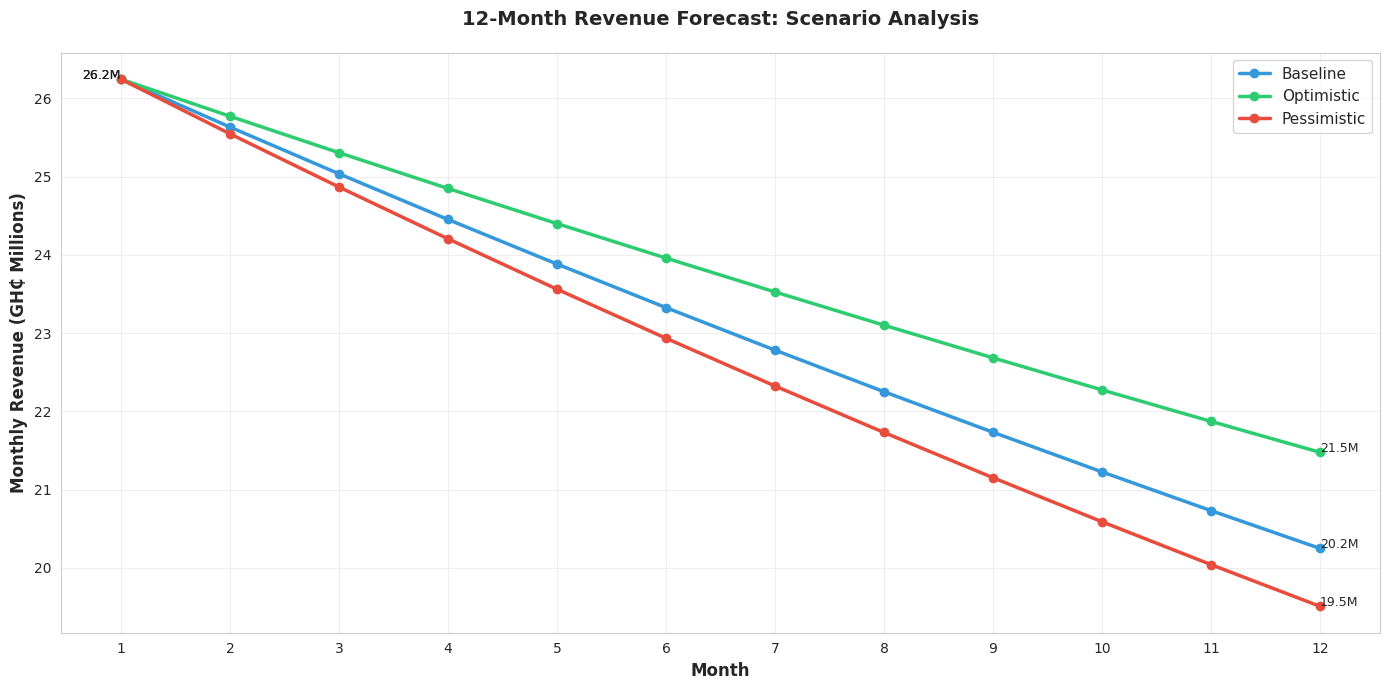

✓ Chart saved: images/revenue_forecast_scenarios.png


In [8]:
# Visualization 1: Monthly Revenue Projection
fig, ax = plt.subplots(figsize=(14, 7))

for scenario_name, forecast_df in forecasts.items():
    ax.plot(
        forecast_df['month'], 
        forecast_df['monthly_revenue'] / 1_000_000,  # Convert to millions
        marker='o',
        linewidth=2.5,
        label=scenario_name,
        color=scenarios[scenario_name]['color']
    )

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Revenue (GH₵ Millions)', fontsize=12, fontweight='bold')
ax.set_title('12-Month Revenue Forecast: Scenario Analysis', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 13))

# Add value labels on first and last points
for scenario_name, forecast_df in forecasts.items():
    first_val = forecast_df['monthly_revenue'].iloc[0] / 1_000_000
    last_val = forecast_df['monthly_revenue'].iloc[-1] / 1_000_000
    ax.text(1, first_val, f'{first_val:.1f}M', fontsize=9, ha='right')
    ax.text(12, last_val, f'{last_val:.1f}M', fontsize=9, ha='left')

plt.tight_layout()
plt.savefig('../images/revenue_forecast_scenarios.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: images/revenue_forecast_scenarios.png")

This chart shows that churn compounds overtime:
- **Month 1:** All scenarios start at ~GH₵26.2M revenue
- **Month 12:** 
  - Baseline drops to ~GH₵19.8M (24% loss)
  - Optimistic ends at ~GH₵21.6M (17% down)
  - Pessimistic falls to ~GH₵18.5M (29% down)

The gap between the best and worst scenarios widens as time goes on. By month 12, there’s a GH₵3.1M difference between the optimistic and pessimistic cases, which is about 17% of the monthly revenue. That’s all from just an 8% difference in churn.

Takeaway: Churn doesn’t hit you all at once — it happens slowly and keeps getting worse. If worked on it early (within the first 1-3 months), damages can be controlled before it piles up.

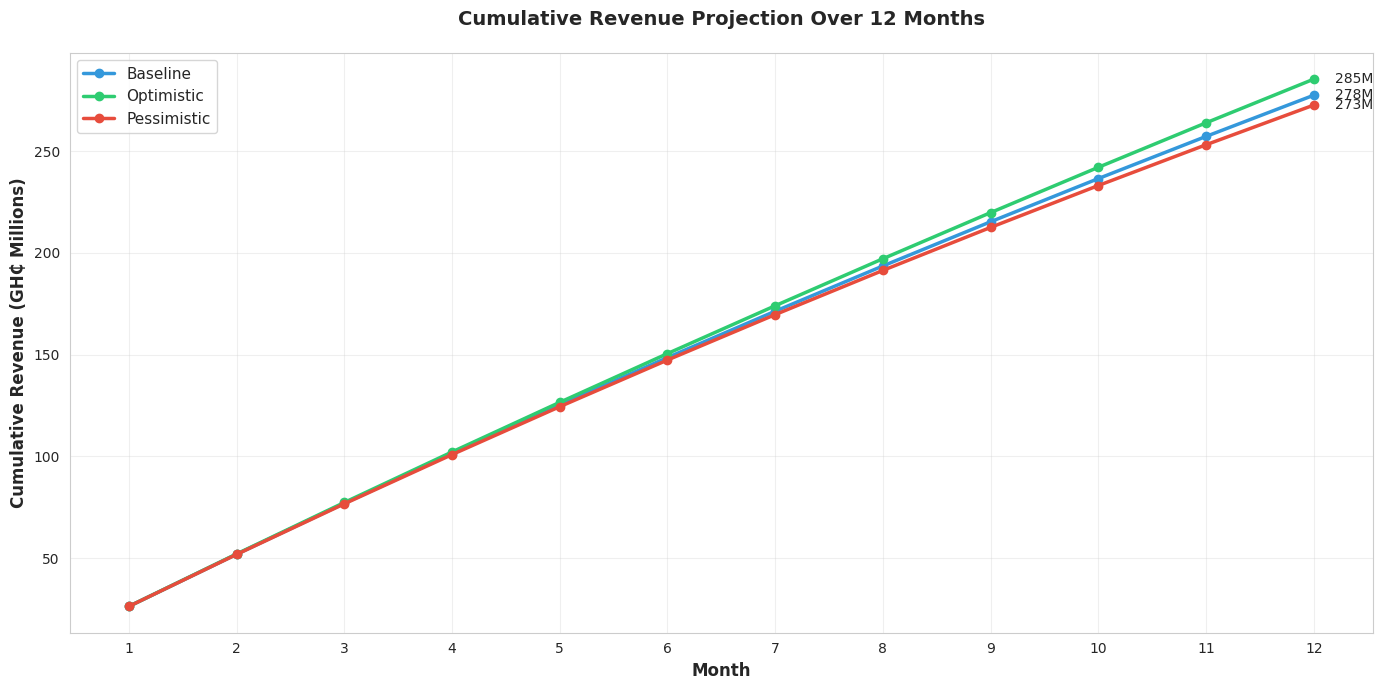

✓ Chart saved: images/cumulative_revenue_comparison.png


In [9]:
# Visualization 2: Cumulative Revenue Comparison
fig, ax = plt.subplots(figsize=(14, 7))

for scenario_name, forecast_df in forecasts.items():
    ax.plot(
        forecast_df['month'], 
        forecast_df['cumulative_revenue'] / 1_000_000,
        marker='o',
        linewidth=2.5,
        label=scenario_name,
        color=scenarios[scenario_name]['color']
    )

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Revenue (GH₵ Millions)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Revenue Projection Over 12 Months', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 13))

# Add final values
for scenario_name, forecast_df in forecasts.items():
    final_val = forecast_df['cumulative_revenue'].iloc[-1] / 1_000_000
    ax.text(12.2, final_val, f'{final_val:.0f}M', fontsize=10, va='center')

plt.tight_layout()
plt.savefig('../images/cumulative_revenue_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: images/cumulative_revenue_comparison.png")

This chart shows how total revenue adds up over the course of 12 months:

- **Baseline:** GHc277.5M
- **Optimistic:** GHc285.5M (+GHc7.9M)
- **Pessimistic:** GHc272.7M (-GHc4.8M)

The GH₵7.9M difference between baseline and optimistic might seem small (2.9%), but:
1. It requires **zero customer acquisition cost** - pure retention
2. At 60% margin, that's **GH₵4.7M profit** drop-through
3. This is just **Year 1** - the saved customers continue generating revenue in future years

**Opportunity cost:** TThe space between the green and blue lines shows the money we're missing out on each month if we don’t step up our retention efforts.

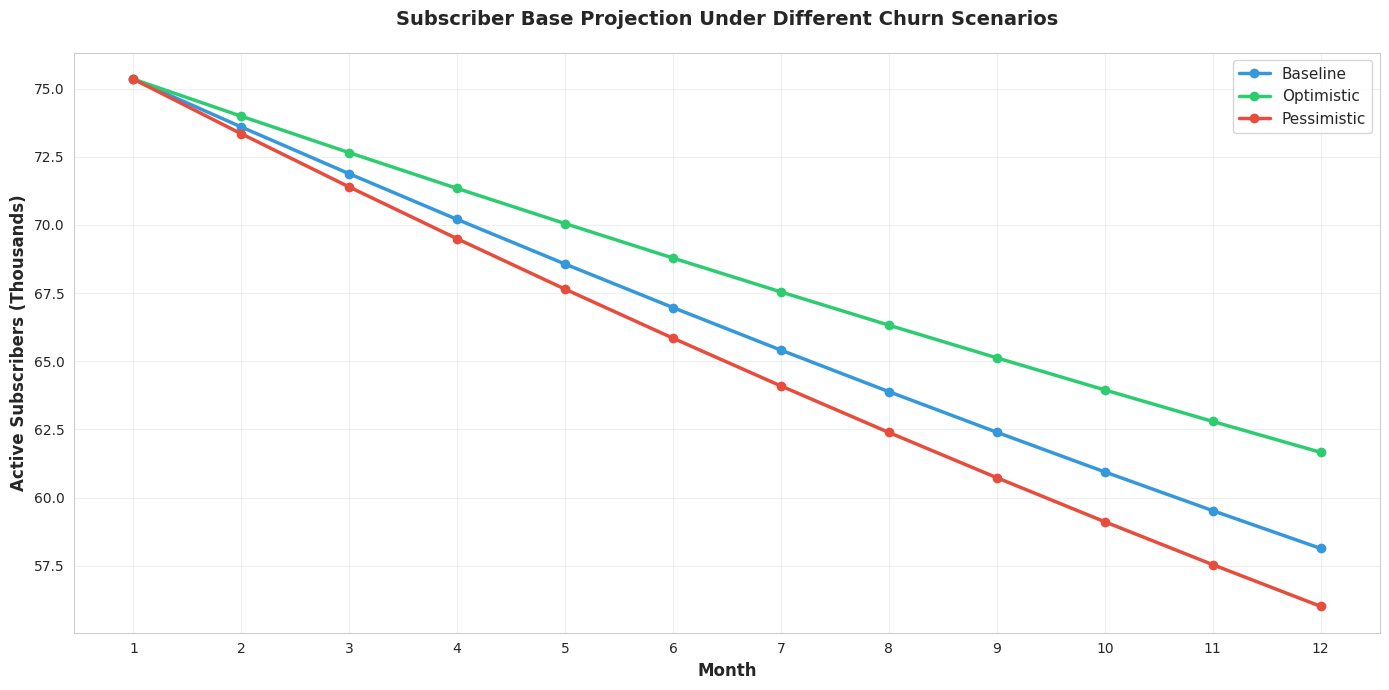

✓ Chart saved: images/subscriber_retention_forecast.png


In [10]:
# Visualization 3: Subscriber Retention Over Time
fig, ax = plt.subplots(figsize=(14, 7))

for scenario_name, forecast_df in forecasts.items():
    ax.plot(
        forecast_df['month'], 
        forecast_df['subscribers'] / 1_000,  # Convert to thousands
        marker='o',
        linewidth=2.5,
        label=scenario_name,
        color=scenarios[scenario_name]['color']
    )

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Active Subscribers (Thousands)', fontsize=12, fontweight='bold')
ax.set_title('Subscriber Base Projection Under Different Churn Scenarios', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, 13))

plt.tight_layout()
plt.savefig('../images/subscriber_retention_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: images/subscriber_retention_forecast.png")

This chart shows how the **active customer base shrinks** under each scenario:

- **Starting point:** 75,350 active customers
- **After 12 months:**
  - Baseline: ~56,700 customers (-18,650 or -24.8%)
  - Optimistic: ~60,500 customers (-14,850 or -19.7%)
  - Pessimistic: ~54,400 customers (-20,950 or -27.8%)

**The 3,767 customer difference** between baseline and optimistic scenarios represents:
- 3,767 × GHc348 ARPU = **GHc1.3M monthly revenue**
- Over their average 42.9-month lifetime = **GHc55.8M total customer value**

**Key takeway:** If we don’t act now, we're looking at a 25% loss in our customer base over the next year. It’s not about growth right now, it’s about stopping the decline first.

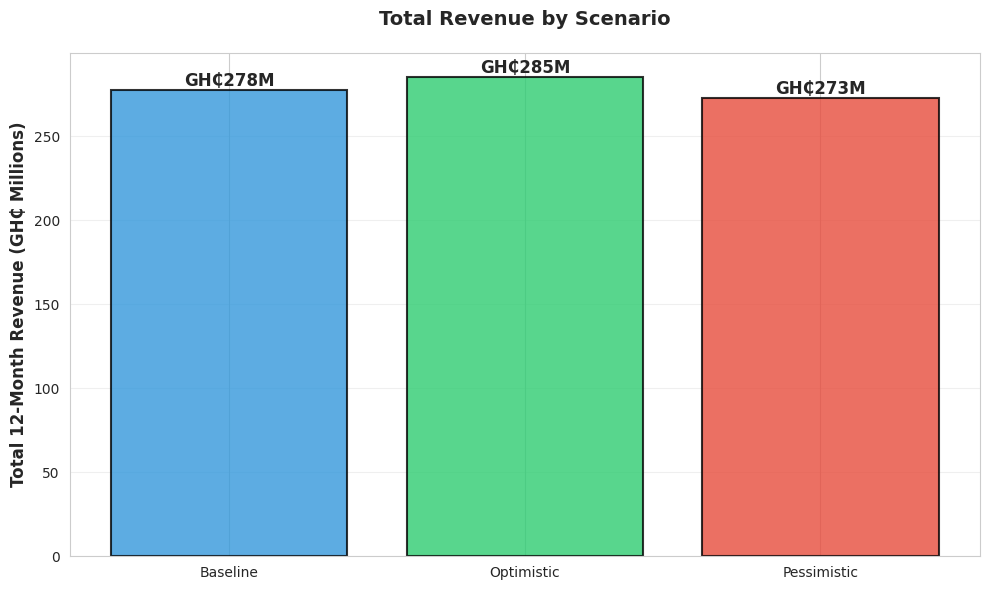

✓ Chart saved: images/revenue_comparison_bar.png


In [11]:
# Visualization 4: Revenue Impact Comparison (Bar Chart)
fig, ax = plt.subplots(figsize=(10, 6))

scenario_names = list(results_summary.keys())
revenues = [results_summary[s]['total_revenue'] / 1_000_000 for s in scenario_names]
colors_list = [scenarios[s]['color'] for s in scenario_names]

bars = ax.bar(scenario_names, revenues, color=colors_list, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, revenue in zip(bars, revenues):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'GH₵{revenue:.0f}M',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Total 12-Month Revenue (GH₵ Millions)', fontsize=12, fontweight='bold')
ax.set_title('Total Revenue by Scenario', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/revenue_comparison_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: images/revenue_comparison_bar.png")

This bar chart provides a simple visual comparison:

| Scenario | Revenue | Profit (60% margin) |
|----------|---------|---------------------|
| Optimistic | GH₵285.5M | GH₵171.3M |
| Baseline | GH₵277.5M | GH₵166.5M |
| Pessimistic | GH₵272.7M | GH₵163.6M |

**The GH₵12.8M swing** between best and worst case represents **4.6% of baseline revenue**. 

For context: If customer acquisition cost (CAC) is GHc50-100 per customer, acquiring 3,767 new customers would cost GH₵188K - GH₵377K, but only maintains revenue. **Retention delivers the same outcome at potentially lower cost** since you're saving existing customers, not acquiring new ones.

---

## 5. Retention ROI Analysis

### Business Question: What's the ROI of investing in customer retention?

Let's calculate the financial justification for retention initiatives.

In [ ]:
# ROI Calculation

# Revenue gain from optimistic scenario
revenue_gain = optimistic_upside
profit_gain = revenue_gain * gross_margin

# Customers saved (difference in retention)
baseline_churned = results_summary['Baseline']['total_churned']
optimistic_churned = results_summary['Optimistic']['total_churned']
customers_saved = baseline_churned - optimistic_churned

print(f"\nRevenue Opportunity (Optimistic vs Baseline):")
print(f"  Additional Revenue: GH₵{revenue_gain:,.2f}")
print(f"  Additional Profit (60% margin): GH₵{profit_gain:,.2f}")
print(f"  Customers Saved from Churning: {customers_saved:,.0f}")

In [21]:
# Calculate max retention spend per customer
# Assumption: Customer Lifetime = 1/churn_rate
avg_customer_lifetime_months = 1 / monthly_churn_rate
customer_lifetime_value = avg_arpu * avg_customer_lifetime_months * gross_margin

print(f"\nCustomer Economics:")
print(f"  Average Customer Lifetime: {avg_customer_lifetime_months:.1f} months")
print(f"  Customer Lifetime Value (CLV): GH₵{customer_lifetime_value:,.2f}")
print(f"  Profit per customer (12 months): GH₵{avg_arpu * 12 * gross_margin:,.2f}")


Customer Economics:
  Average Customer Lifetime: 42.9 months
  Customer Lifetime Value (CLV): GH₵8,965.69
  Profit per customer (12 months): GH₵2,507.84


In [22]:

# ROI scenarios for retention spend
retention_spend_scenarios = [50, 100, 200, 300]

print(f"\n{'Retention Spend/Customer':<25} {'Customers Saved':<20} {'Total Cost':<20} {'Profit Gain':<20} {'Net ROI':<15}")
print("-" * 100)

for spend in retention_spend_scenarios:
    total_cost = spend * customers_saved
    net_profit = profit_gain - total_cost
    roi = (net_profit / total_cost) * 100 if total_cost > 0 else 0
    
    print(f"GH₵{spend:<23,.0f} {customers_saved:<20,.0f} GH₵{total_cost:<18,.0f} GH₵{profit_gain:<18,.0f} {roi:>14,.0f}%")




Retention Spend/Customer  Customers Saved      Total Cost           Profit Gain          Net ROI        
----------------------------------------------------------------------------------------------------
GH₵50                      3,526                GH₵176,321            GH₵4,748,251                   2,593%
GH₵100                     3,526                GH₵352,641            GH₵4,748,251                   1,246%
GH₵200                     3,526                GH₵705,283            GH₵4,748,251                     573%
GH₵300                     3,526                GH₵1,057,924          GH₵4,748,251                     349%


**Even spending GH₵300 per customer on retention yields positive ROI**